In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
from math import ceil
import matplotlib.gridspec as gridspec
import pandas as pd
from hsemotion_onnx.facial_emotions import HSEmotionRecognizer
import seaborn as sns
import matplotlib.ticker as ticker

%matplotlib inline

In [6]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

#Do not forget to run pip install facenet-pytorch
from facenet_pytorch import MTCNN
mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=40, device=device)

def detect_face(frame):
    bounding_boxes, probs = mtcnn.detect(frame, landmarks=False)
    bounding_boxes=bounding_boxes[probs>0.9]
    return bounding_boxes

print(use_cuda)

c:\Users\F\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False


c:\Users\F\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  device: torch.device = torch.device("cpu"),


In [7]:
face_img = cv2.imread(r'C:\Users\F\Documents\1 UM\Semester 2\group12\fer\preprocessed\Val\mtcnn_aligned\video1\0027\0.png')

In [157]:
model_name='enet_b0_8_best_afew'
fer=HSEmotionRecognizer(model_name=model_name)
emotion,scores=fer.predict_emotions(face_img,logits=False)

In [158]:
# Initialize the emotion recognizer
model_name='enet_b0_8_best_afew'
fer=HSEmotionRecognizer(model_name=model_name)

# Prepare a dataframe to store the results
df = pd.DataFrame(columns=['Video', 'Frame', 'Face', 'Emotion'])

# Base directory
base_dir = 'preprocessed/Val/mtcnn_aligned'

# Iterate over all videos in the directory
for video_name in os.listdir(base_dir):
    video_dir = os.path.join(base_dir, video_name)
    
    # Iterate over all frames in the video directory
    for frame_name in os.listdir(video_dir):
        frame_dir = os.path.join(video_dir, frame_name)
        
        # Iterate over all faces in the frame directory
        for face_name in os.listdir(frame_dir):
            face_path = os.path.join(frame_dir, face_name)
            
            # Load the image
            face_img = cv2.imread(face_path)
            
            # Predict the emotion
            emotion, scores = fer.predict_emotions(face_img, logits=False)
            
            # Append the result to the dataframe
            df = df.append({
                'Video': video_name,
                'Frame': frame_name,
                'Face': face_name,
                'Emotion': emotion
            }, ignore_index=True)

# Save the dataframe to a csv file
df.to_csv('emotion_predictions.csv', index=False)


In [ ]:
# Paths
video_name = '2023-05-10 16-46-42'
frame_number = "0297"
frames_dir = f'preprocessed/Val/frames/{video_name}'
aligned_faces_dir = f'preprocessed/Val/mtcnn_aligned/{video_name}/{frame_number}'

# Load the original frame for displaying
original_frame = cv2.imread(os.path.join(frames_dir, f'{frame_number}.png'))
original_frame_rgb = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)

# Iterate over each face image in the frame directory
for face_idx, face_image_name in enumerate(sorted(os.listdir(aligned_faces_dir))):
    # Load face image
    face_img_path = os.path.join(aligned_faces_dir, face_image_name)
    face_img = cv2.imread(face_img_path)

    # Predict emotion
    emotion, _ = fer.predict_emotions(face_img, logits=False)

    # Annotate original frame with emotion
    cv2.putText(original_frame_rgb, f'Face {face_idx}: {emotion}', (20, 30 + face_idx * 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

# Display the original frame with emotions using matplotlib
plt.imshow(original_frame_rgb)
plt.axis('off')  # To hide the axis
plt.show()


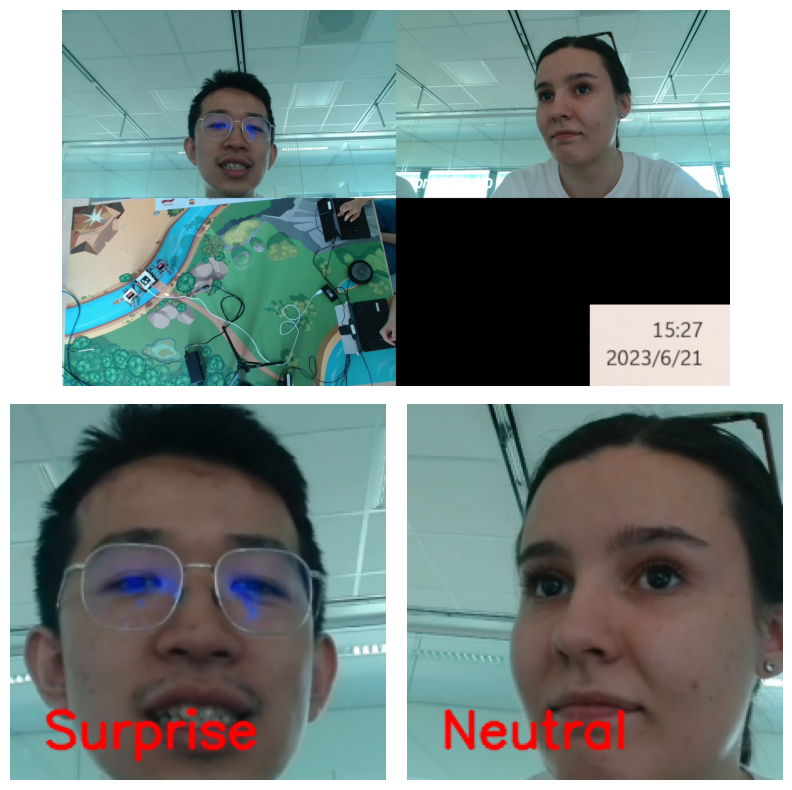

In [85]:
# Paths
video_name = "video2"
frame_number = "0190"
frames_dir = f'preprocessed/Val/frames/{video_name}'
aligned_faces_dir = f'preprocessed/Val/mtcnn_aligned/{video_name}/{frame_number}'

# Load the original frame for displaying
original_frame = cv2.imread(os.path.join(frames_dir, f'{frame_number}.png'))
original_frame_rgb = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)

# Initialize list to store face images and their emotions
face_imgs_with_emotions = []

# Iterate over each face image in the frame directory
for face_image_name in sorted(os.listdir(aligned_faces_dir)):
    # Load face image
    face_img_path = os.path.join(aligned_faces_dir, face_image_name)
    face_img = cv2.imread(face_img_path)

    # Predict emotion
    emotion, _ = fer.predict_emotions(face_img, logits=False)

    # Annotate face image with emotion
    face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    cv2.putText(face_img_rgb, emotion, (20, face_img_rgb.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    
    # Append to list
    face_imgs_with_emotions.append(face_img_rgb)

# Create figure with original frame and faces
fig = plt.figure(figsize=(10, ceil((len(face_imgs_with_emotions) + 1) / 2) * 5))

# Create a GridSpec for the figure
gs = gridspec.GridSpec(2, 1, figure=fig)

# Add original frame to the top of the GridSpec
ax_frame = fig.add_subplot(gs[0, 0])
ax_frame.imshow(original_frame_rgb)
ax_frame.axis('off')

# Create a nested GridSpec for the face images
inner_grid = gridspec.GridSpecFromSubplotSpec(1, len(face_imgs_with_emotions), subplot_spec=gs[1, 0])

# Display each face image in the nested GridSpec
for i, face_img_rgb in enumerate(face_imgs_with_emotions):
    ax = fig.add_subplot(inner_grid[0, i])
    ax.imshow(face_img_rgb)
    ax.axis('off')

# Adjust spacing and show the plot
fig.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()


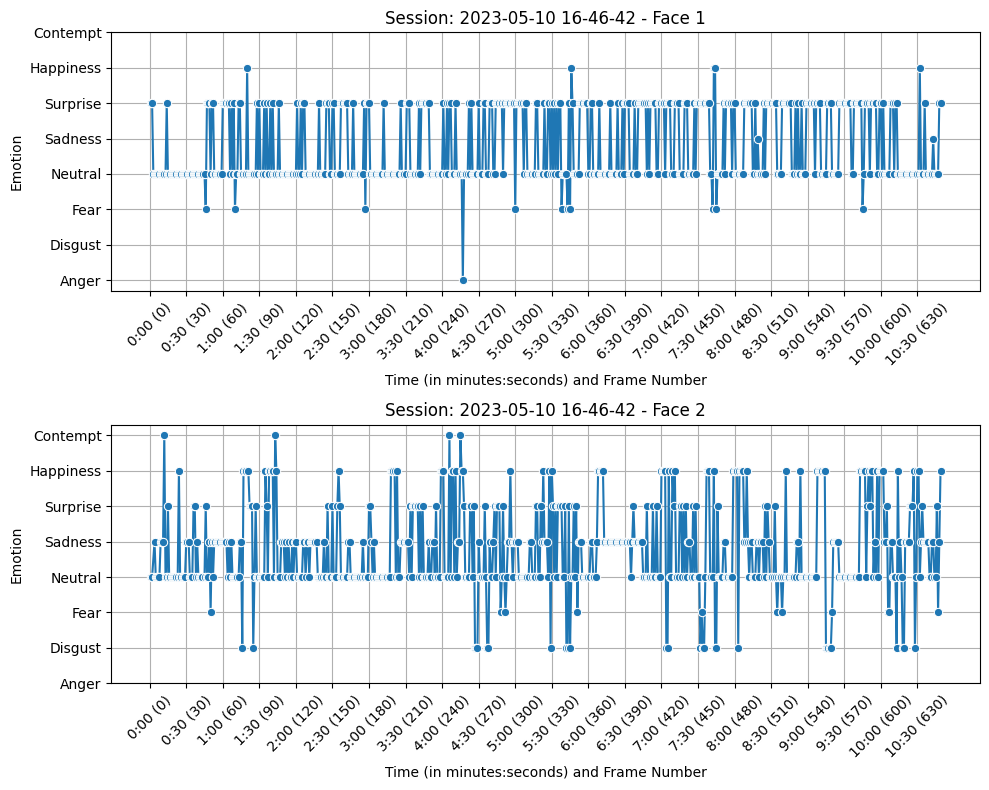

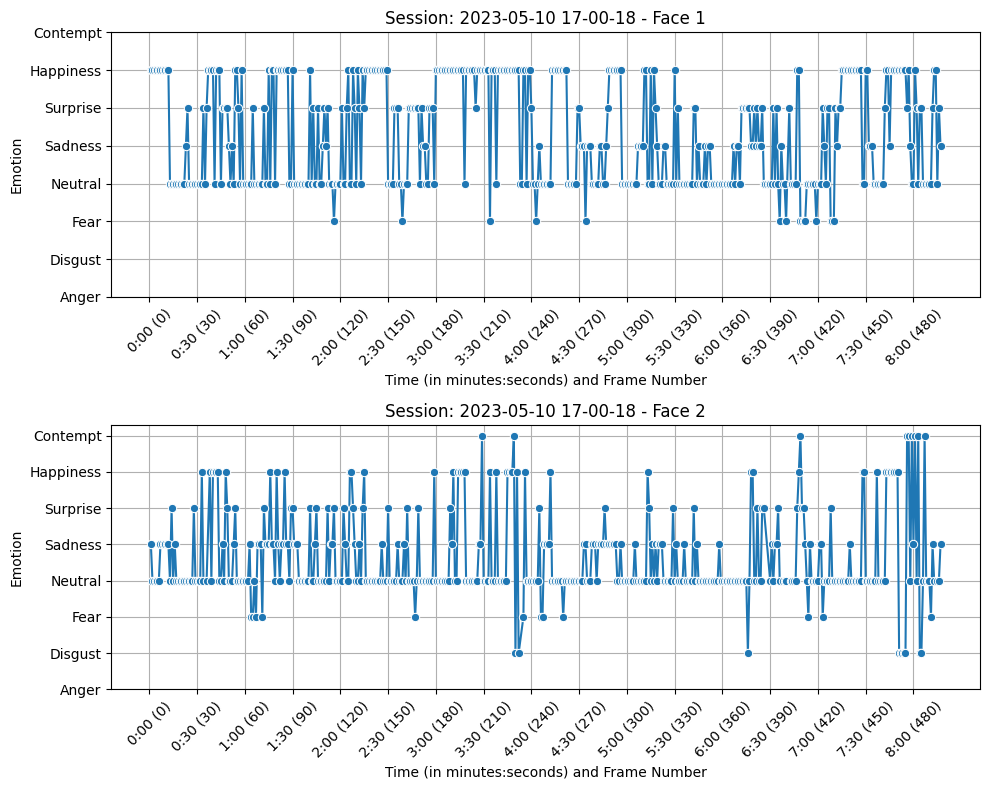

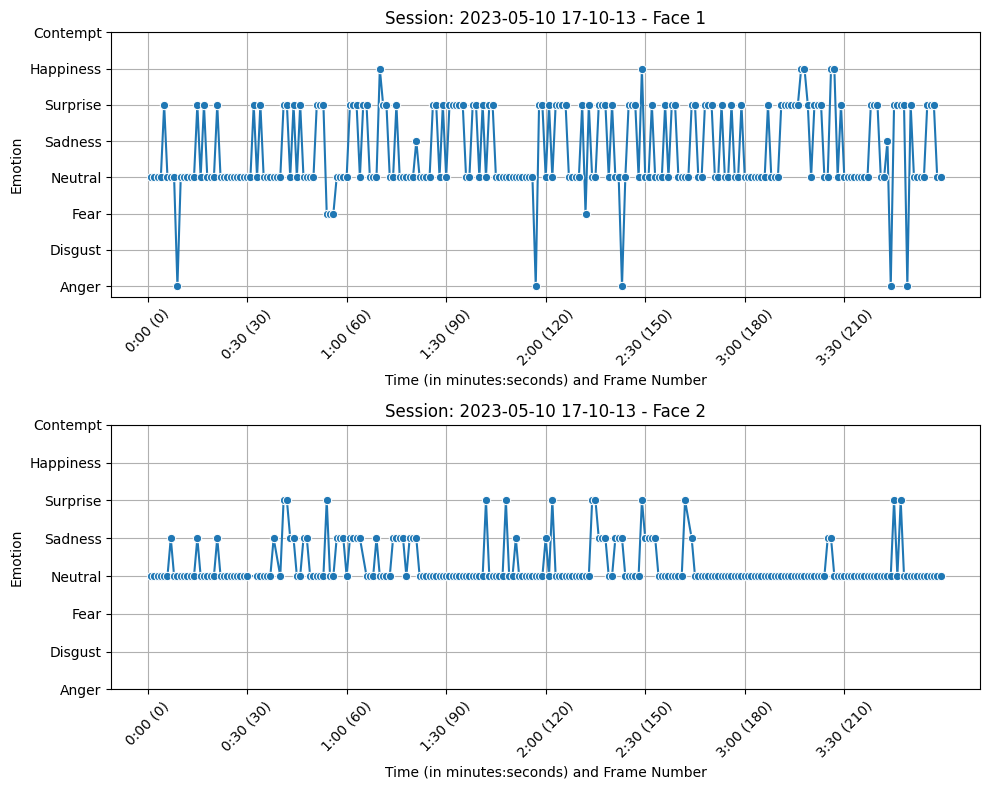

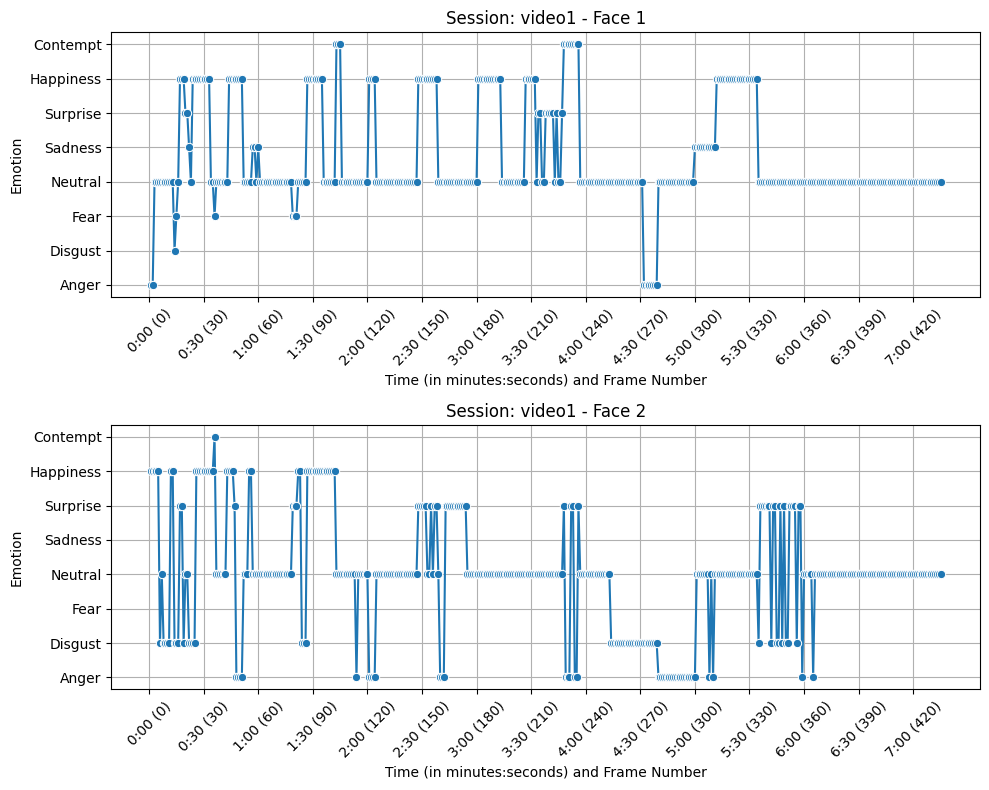

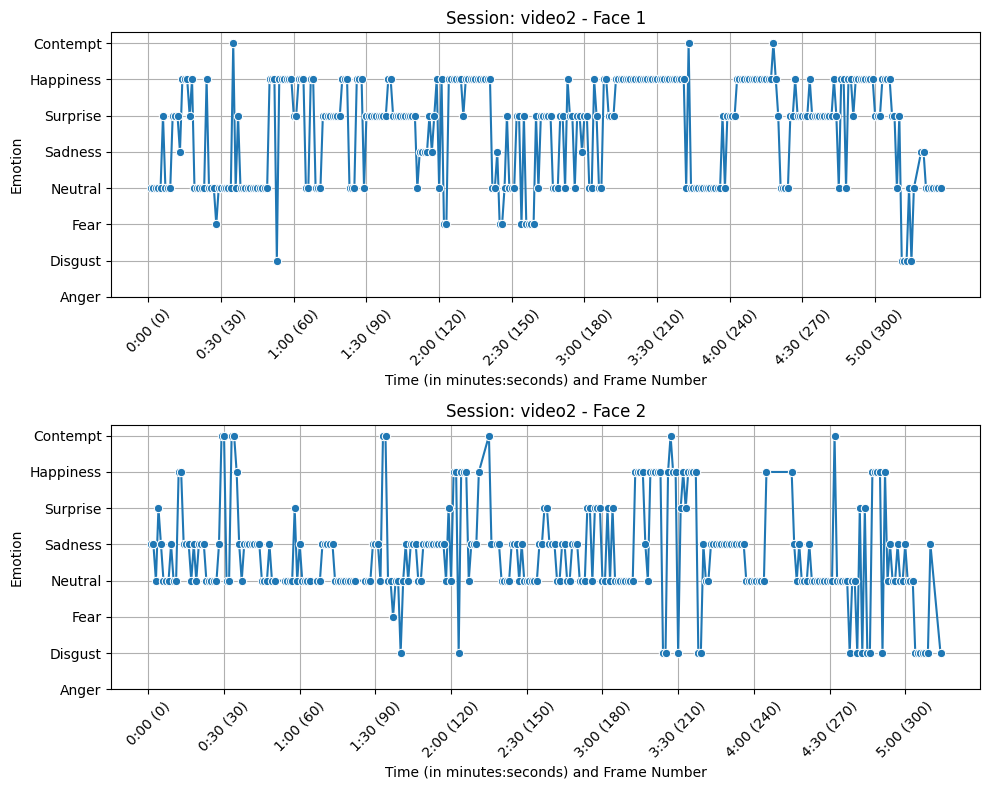

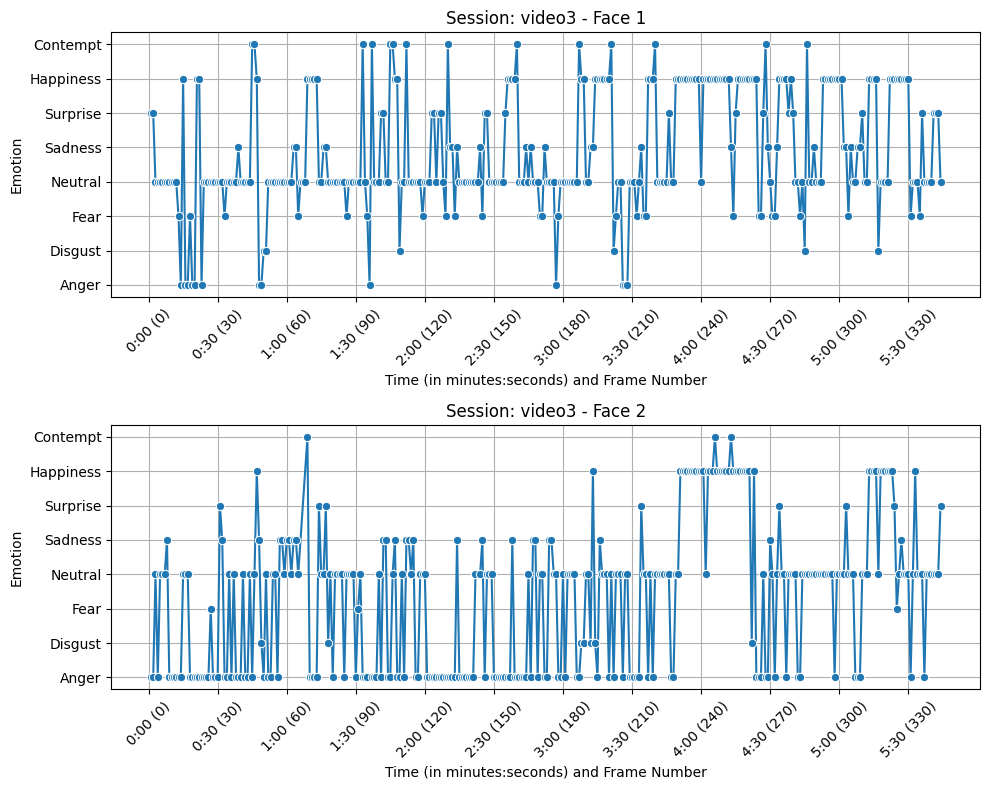

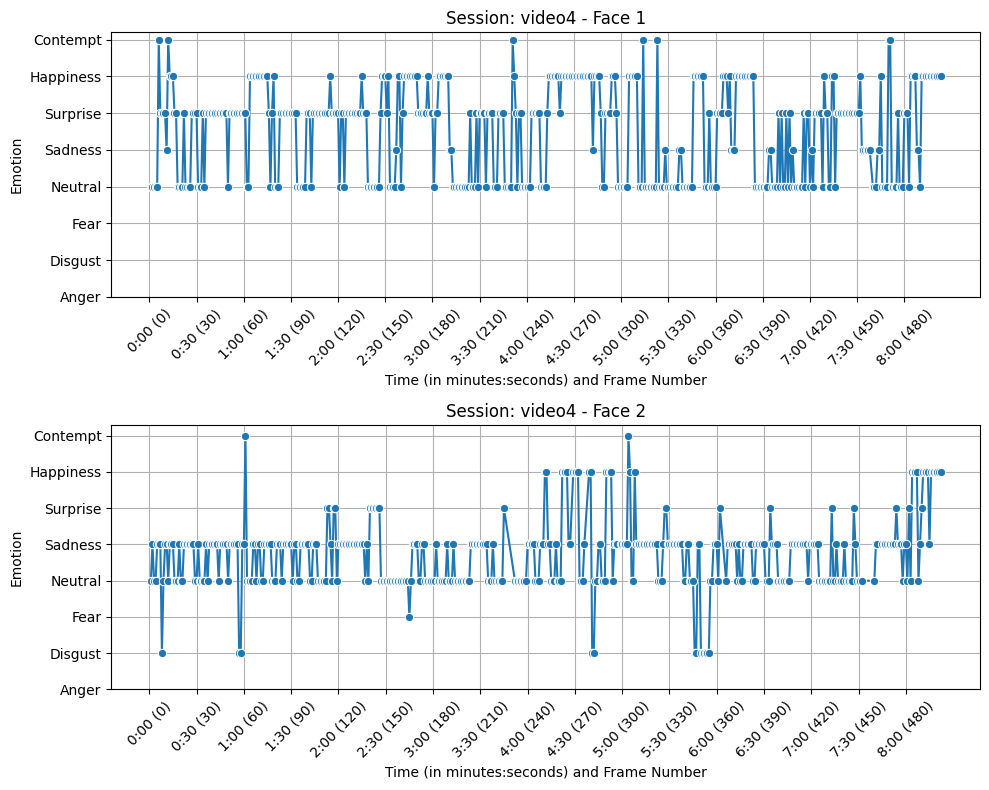

In [173]:
# Read the CSV file
df = pd.read_csv('emotion_predictions.csv')

# Filter the dataframe for the relevant faces only
df = df[df['Face'].isin(['0.png', '1.png'])]


emotion_mapping = {'Anger': 1, 'Disgust': 2, 'Fear': 3, 'Neutral': 4, 'Sadness': 5, 'Surprise': 6, 'Happiness': 7, 'Contempt':8 }
df['Emotion'] = df['Emotion'].map(emotion_mapping)

# Create time column, assuming 1 frame per second
df['Time'] = pd.to_timedelta(df['Frame'], unit='s')

# Get the unique videos
videos = df['Video'].unique()

# Create a separate plot for each video
for video in videos:
    # Get the data for this video
    temp_df = df[df['Video'] == video]

    # Create a figure with a subplot for each face
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    for i, face in enumerate(['0.png', '1.png']):
        # Get the data for this face
        face_df = temp_df[temp_df['Face'] == face]

        # Create a line plot on the appropriate subplot
        ax = axs[i]
        sns.lineplot(x='Frame', y='Emotion', data=face_df, ax=ax, marker='o', sort=False)
        ax.set_title(f'Session: {video} - Face {i+1}')
        ax.set_xlabel('Time (in minutes:seconds) and Frame Number')
        ax.set_ylabel('Emotion')
        ax.set_yticks(range(1, 9))
        ax.set_yticklabels(list(emotion_mapping.keys()))
        
        xticks = np.arange(0, face_df['Frame'].max(), 30)  # Set xticks every 10 frames
        ax.set_xticks(xticks)
        ax.set_xticklabels([f'{tick//60}:{tick%60:02d} ({tick})' for tick in xticks], rotation=45)
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [95]:
import cv2
import matplotlib.pyplot as plt
import os
from math import ceil
import matplotlib.gridspec as gridspec

def plot_faces_and_emotions(video_number, frame_number):
    # Format inputs
    video_name = f"video{video_number}"
    frame_number_str = f"{frame_number:04d}"  # Format the frame number as a 4-digit string

    # Paths
    frames_dir = f'preprocessed/Val/frames/{video_name}'
    aligned_faces_dir = f'preprocessed/Val/mtcnn_aligned/{video_name}/{frame_number_str}'

    # Load the original frame for displaying
    original_frame = cv2.imread(os.path.join(frames_dir, f'{frame_number_str}.png'))
    original_frame_rgb = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)

    # Initialize list to store face images and their emotions
    face_imgs_with_emotions = []

    # Iterate over each face image in the frame directory
    for face_image_name in sorted(os.listdir(aligned_faces_dir)):
        # Load face image
        face_img_path = os.path.join(aligned_faces_dir, face_image_name)
        face_img = cv2.imread(face_img_path)

        # Predict emotion
        emotion, _ = fer.predict_emotions(face_img, logits=False)

        # Annotate face image with emotion
        face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        cv2.putText(face_img_rgb, emotion, (20, face_img_rgb.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        # Append to list
        face_imgs_with_emotions.append(face_img_rgb)

    # Create figure with original frame and faces
    fig = plt.figure(figsize=(10, ceil((len(face_imgs_with_emotions) + 1) / 2) * 5))

    # Create a GridSpec for the figure
    gs = gridspec.GridSpec(2, 1, figure=fig)

    # Add original frame to the top of the GridSpec
    ax_frame = fig.add_subplot(gs[0, 0])
    ax_frame.imshow(original_frame_rgb)
    ax_frame.axis('off')

    # Create a nested GridSpec for the face images
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, len(face_imgs_with_emotions), subplot_spec=gs[1, 0])

    # Display each face image in the nested GridSpec
    for i, face_img_rgb in enumerate(face_imgs_with_emotions):
        ax = fig.add_subplot(inner_grid[0, i])
        ax.imshow(face_img_rgb)
        ax.axis('off')

    # Adjust spacing and show the plot
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.show()


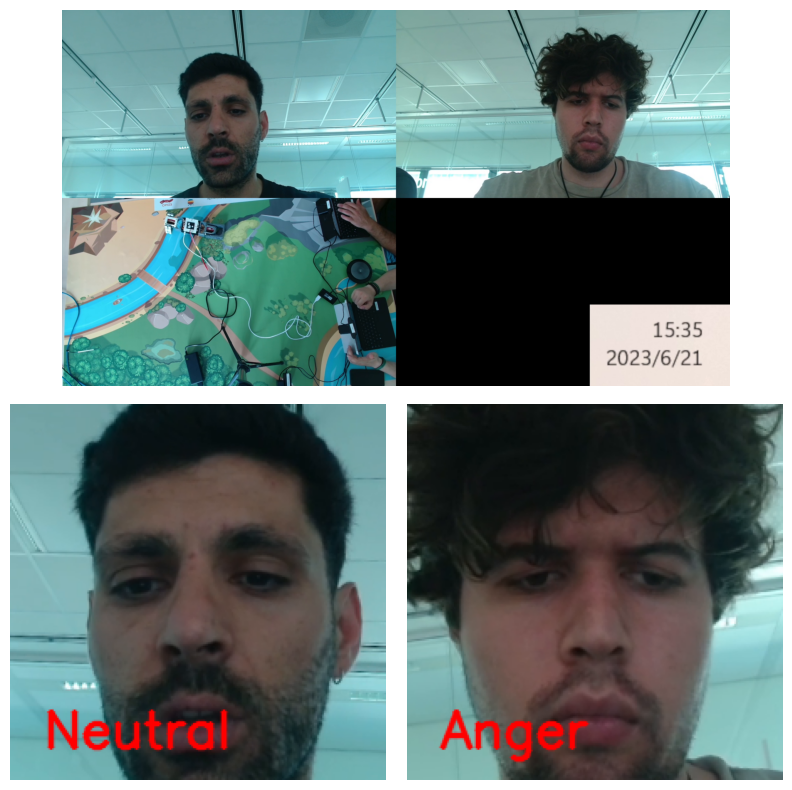

In [99]:
plot_faces_and_emotions(3,125)

In [162]:
import plotly.graph_objects as go

# Read the CSV file
df = pd.read_csv('emotion_predictions.csv')

# Filter the dataframe for the relevant faces only
df = df[df['Face'].isin(['0.png', '1.png'])]

emotion_mapping = {'Anger': 1, 'Disgust': 2, 'Fear': 3, 'Neutral': 4, 'Sadness': 5, 'Surprise': 6, 'Happiness': 7, 'Contempt': 8}
reverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}  # Reverse mapping for emotion name
df['Emotion'] = df['Emotion'].map(emotion_mapping)

# Get the unique videos
videos = df['Video'].unique()

# Create a separate plot for each video
for video in videos:
    # Get the data for this video
    temp_df = df[df['Video'] == video]
    i = 0
    for face in ['0.png', '1.png']:
        i += 1
        # Get the data for this face
        face_df = temp_df[temp_df['Face'] == face]

        # Create a line plot on the appropriate subplot
        fig = go.Figure()

        fig.add_trace(go.Scatter(x=face_df['Frame'], 
                                 y=face_df['Emotion'],
                                 mode='markers',
                                 marker=dict(size=6),
                                 text=[f'Frame: {f}, Emotion: {reverse_emotion_mapping[e]}' for f, e in zip(face_df['Frame'], face_df['Emotion'])],
                                 hoverinfo='text'))

        fig.update_layout(title=f'{video} - Face {i}',
                          xaxis_title='Frame Number',
                          yaxis_title='Emotion',
                          yaxis=dict(tickmode='array',
                                     tickvals=list(emotion_mapping.values()),
                                     ticktext=list(emotion_mapping.keys())),
                          xaxis=dict(tickmode='linear',
                                     tick0=0,
                                     dtick=10))

        fig.show()


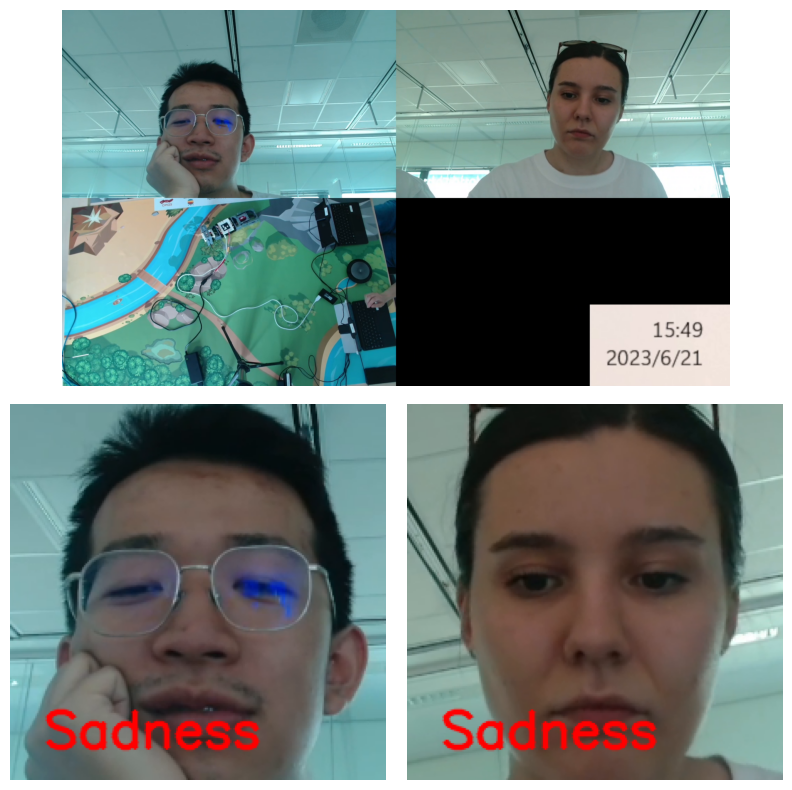

In [175]:
plot_faces_and_emotions(4,372)

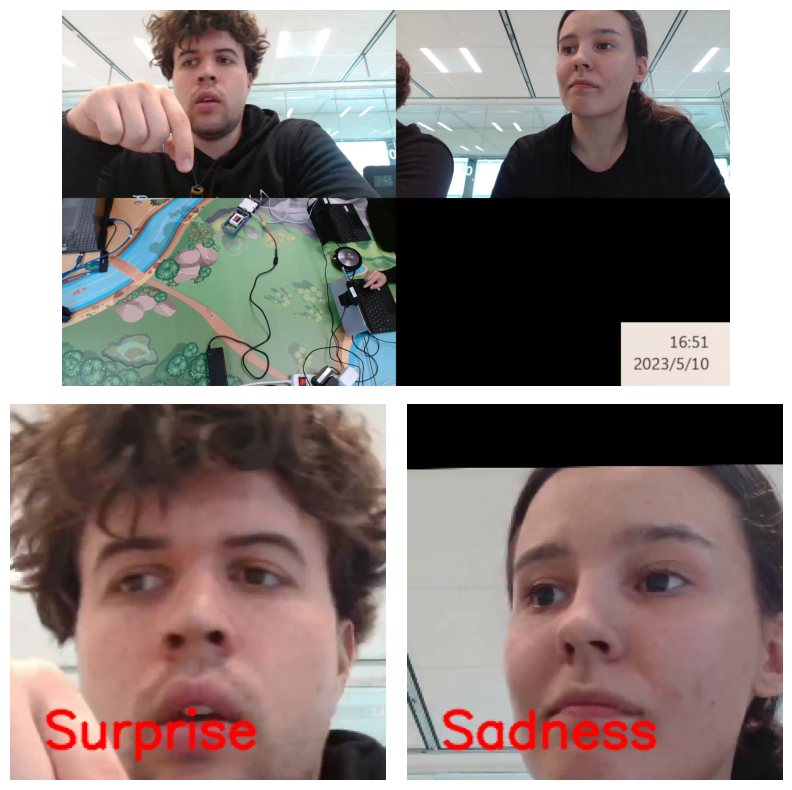

In [170]:
# Paths
video_name = '2023-05-10 16-46-42'
frame_number = "0297"
frames_dir = f'preprocessed/Val/frames/{video_name}'
aligned_faces_dir = f'preprocessed/Val/mtcnn_aligned/{video_name}/{frame_number}'

# Load the original frame for displaying
original_frame = cv2.imread(os.path.join(frames_dir, f'{frame_number}.png'))
original_frame_rgb = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)

# Initialize list to store face images and their emotions
face_imgs_with_emotions = []

# Iterate over each face image in the frame directory
for face_image_name in sorted(os.listdir(aligned_faces_dir)):
    # Load face image
    face_img_path = os.path.join(aligned_faces_dir, face_image_name)
    face_img = cv2.imread(face_img_path)

    # Predict emotion
    emotion, _ = fer.predict_emotions(face_img, logits=False)

    # Annotate face image with emotion
    face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    cv2.putText(face_img_rgb, emotion, (20, face_img_rgb.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    
    # Append to list
    face_imgs_with_emotions.append(face_img_rgb)

# Create figure with original frame and faces
fig = plt.figure(figsize=(10, ceil((len(face_imgs_with_emotions) + 1) / 2) * 5))

# Create a GridSpec for the figure
gs = gridspec.GridSpec(2, 1, figure=fig)

# Add original frame to the top of the GridSpec
ax_frame = fig.add_subplot(gs[0, 0])
ax_frame.imshow(original_frame_rgb)
ax_frame.axis('off')

# Create a nested GridSpec for the face images
inner_grid = gridspec.GridSpecFromSubplotSpec(1, len(face_imgs_with_emotions), subplot_spec=gs[1, 0])

# Display each face image in the nested GridSpec
for i, face_img_rgb in enumerate(face_imgs_with_emotions):
    ax = fig.add_subplot(inner_grid[0, i])
    ax.imshow(face_img_rgb)
    ax.axis('off')

# Adjust spacing and show the plot
fig.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()


In [151]:
#import subprocess

#res of the vid
#width, height = 3840, 2160

#selecting bottom left corner
#crop_width, crop_height = width // 2, height // 2
#x, y = 0, height // 2

#command = f'ffmpeg -i "C:\\Users\\F\\Downloads\\video1.mkv" -filter:v "crop={crop_width}:{crop_height}:{x}:{y}" "C:\\Users\\F\\Downloads\\output.mp4"'
#subprocess.call(command, shell=True)


0